In [3]:
import os
import numpy as np
import torch as tc
import torchvision as tv
import pandas as pd
import matplotlib.pyplot as plt
!pip install SimpleITK
import SimpleITK as sitk
from torch.utils.tensorboard import SummaryWriter
import random
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

%cd /content/drive/MyDrive/Kaggle/

!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

%ls
%cp -av "/content/drive/MyDrive/Kaggle" "/content/Kaggle"

A saída de streaming foi truncada nas últimas 5000 linhas.
'/content/drive/MyDrive/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(235).jpg' -> '/content/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(235).jpg'
'/content/drive/MyDrive/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(221).jpg' -> '/content/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(221).jpg'
'/content/drive/MyDrive/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(216).jpg' -> '/content/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(216).jpg'
'/content/drive/MyDrive/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(224).jpg' -> '/content/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(224).jpg'
'/content/drive/MyDrive/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(230).jpg' -> '/content/Kaggle/Chest_Xray_Covid19_Pneumonia/Data/train/COVID19/COVID19(230).jpg'
'/content/drive/MyDrive/Ka

In [6]:
input_file = "/content/Kaggle/chest-xray-covid19-pneumonia.zip"
output_folder =  "/content/Kaggle/Chest_Xray_Covid19_Pneumonia" # Path to the folder where you would like to unzip the "archive.zip"
# Note - it will require about 5GB of free Google Drive memory.

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

#!unzip {input_file} -d {output_folder} # Do this only once, them comment out this command

Input file path: /content/Kaggle/chest-xray-covid19-pneumonia.zip
Output folder path: /content/Kaggle/Chest_Xray_Covid19_Pneumonia


In [13]:
class XRayDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataset_path = dataset_path
        self.dataframe = pd.read_csv(self.csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        current_path = os.path.join(self.dataset_path, current_case['Image Path'])

        current_image = Image.open(current_path)
        
        channels = len(current_image.getbands())
        if channels != 3:
          current_image = current_image.convert(mode='RGB')

        current_image = tv.transforms.functional.pil_to_tensor(current_image)
        current_image = tv.transforms.Resize(size=(224,224), interpolation=tv.transforms.InterpolationMode.BILINEAR)(current_image)
        current_image = current_image.type(tc.float)
        current_image = tv.transforms.Normalize(mean=(0.5), std=(0.5))(current_image)
        
        return current_image

In [8]:
data_path = os.path.join(output_folder, "Data")
csv_path = os.path.join(data_path, "dataset.csv")
path_to_training_set = os.path.join(data_path, "train")
path_to_testing_set = os.path.join(data_path, "test")

dataset = []
for folder_name in os.listdir(path_to_training_set):
  for case_name in os.listdir(os.path.join(path_to_training_set, folder_name)):
    current_case = os.path.join("train", os.path.join(folder_name, case_name))
    dataset.append(current_case)

for folder_name in os.listdir(path_to_testing_set):
  for case_name in os.listdir(os.path.join(path_to_testing_set, folder_name)):
    current_case = os.path.join("test", os.path.join(folder_name, case_name))
    dataset.append(current_case)

dataframe = pd.DataFrame(dataset, columns=["Image Path"])
dataframe.to_csv(csv_path, index=False)
print(f"Dataset size: {len(dataframe)}")

Dataset size: 6410


Dataset size: 6410


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


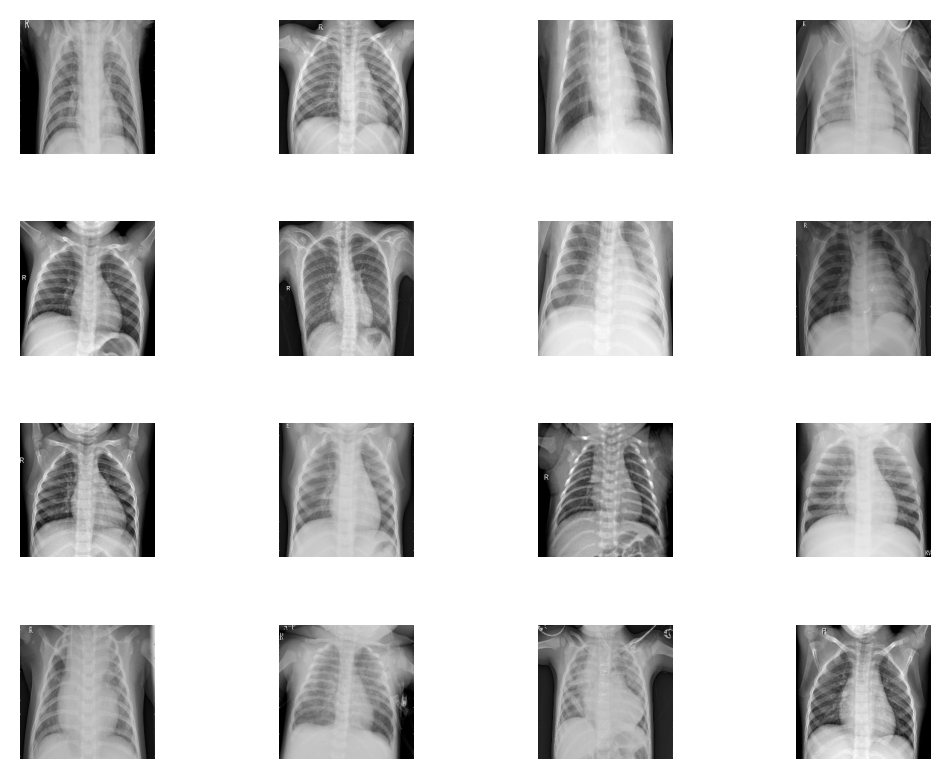

In [14]:
batch_size = 16
shuffle = True
dataset = XRayDataset(data_path, csv_path)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

print(f"Dataset size: {len(dataset)}")

plt.figure(dpi=200)
i = 1

for images in dataloader:
  plt.subplot(4, 4, i)
  plt.imshow(images[0, 0, :, :], cmap='gray')
  plt.subplots_adjust(hspace=0.5)
  plt.axis('off')
  i += 1
  if i > 4*4:
    break

In [22]:
from typing import Iterable

class ConvBuildingBlock(tc.nn.Module):
  def __init__(
      self,
      input_channels : int,
      output_channels : int,
      ) -> None:

      super(ConvBuildingBlock, self).__init__()
      self.network = tc.nn.Sequential(
          tc.nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, padding=1),
          tc.nn.BatchNorm2d(num_features=output_channels),
          tc.nn.LeakyReLU(0.05)
      )

  def forward(self, x : tc.Tensor) -> tc.Tensor:
    return self.network(x)

class UNetEncoder(tc.nn.Module):
  def __init__(
      self,
      input_channels : int,
      blocks_per_channel : Iterable[int],
      input_channels_per_channel : Iterable[int],
      output_channels_per_channel : Iterable[int]):
      """
      TODO
      """
      super(UNetEncoder, self).__init__()

      self.input_channels = input_channels
      self.blocks_per_channel = blocks_per_channel
      self.input_channels_per_channel = input_channels_per_channel
      self.output_channels_per_channel = output_channels_per_channel
      self.num_layers = len(self.input_channels_per_channel)

      if len(self.blocks_per_channel) != len(self.input_channels_per_channel):
        raise ValueError("Descriptive message.")

      for i, (icpc, ocpc, bpc) in enumerate(zip(self.input_channels_per_channel, self.output_channels_per_channel, self.blocks_per_channel)):
        module_list = []
        for j in range(bpc):
          if j == 0:
            module_list.append(ConvBuildingBlock(icpc, ocpc))
          else:
            module_list.append(ConvBuildingBlock(ocpc, ocpc))
        ic = icpc if bpc == 0 else ocpc
        module_list.append(tc.nn.Conv2d(ic, ocpc, 4, stride=2, padding=1))
        module_list.append(tc.nn.BatchNorm2d(num_features=ocpc))
        module_list.append(tc.nn.LeakyReLU(0.05))
        layer = tc.nn.Sequential(*module_list)
        setattr(self, f"encoder_{i}", layer) # <- self.encoder_0 = layer

  def forward(self, x : tc.Tensor) -> Iterable[tc.Tensor]:
    for i in range(self.num_layers):
      x = getattr(self, f"encoder_{i}")(x)
    return x

class UNetDecoder(tc.nn.Module):
  def __init__(
      self,
      input_channels : int,
      blocks_per_channel : Iterable[int],
      input_channels_per_channel : Iterable[int],
      output_channels_per_channel : Iterable[int]):
    
    super(UNetDecoder, self).__init__()
    
    self.input_channels = input_channels
    self.blocks_per_channel = blocks_per_channel
    self.input_channels_per_channel = input_channels_per_channel
    self.output_channels_per_channel = output_channels_per_channel
    self.num_layers = len(self.input_channels_per_channel)

    if len(self.blocks_per_channel) != len(self.input_channels_per_channel):
      raise ValueError("Descriptive message.")

    for i, (icpc, ocpc, bpc) in enumerate(zip(self.input_channels_per_channel, self.output_channels_per_channel, self.blocks_per_channel)):
      module_list = []
      for j in range(bpc):
        if j == 0:
          module_list.append(ConvBuildingBlock(icpc, ocpc))
        else:
          module_list.append(ConvBuildingBlock(ocpc, ocpc))
      ic = icpc if bpc == 0 else ocpc
      module_list.append(tc.nn.ConvTranspose2d(ic, ocpc, 4, stride=2, padding=1))
      module_list.append(tc.nn.InstanceNorm2d(num_features=ocpc))
      module_list.append(tc.nn.LeakyReLU(0.05))
      layer = tc.nn.Sequential(*module_list)
      setattr(self, f"decoder{i}", layer) # <- self.encoder_0 = layer
  
  def forward(self, embeddings : Iterable[tc.Tensor]) -> tc.Tensor:
    for i in range(self.num_layers-1, -1, -1):
      x = getattr(self, f"decoder{i}")(x)
    return x

In [25]:
class AutoEncoder(tc.nn.Module):
    def __init__(
      self,
      input_channels : int,
      output_channels : int,
      blocks_per_encoder_channel : Iterable[int],
      blocks_per_decoder_channel : Iterable[int]):
      
      super(AutoEncoder, self).__init__()
      self.input_channels = input_channels
      self.output_channels = output_channels
      self.blocks_per_encoder_channel = blocks_per_encoder_channel
      self.blocks_per_decoder_channel = blocks_per_decoder_channel

      self.encoder = UNetEncoder(input_channels=self.input_channels, 
                                 blocks_per_channel=self.blocks_per_encoder_channel, 
                                 input_channels_per_channel=[self.input_channels, 16, 32, 64], 
                                 output_channels_per_channel=[16, 32, 64, 128])
        
      self.pool = tc.nn.AdaptiveAvgPool2d((1, 1))

      self.linear_decoder = tc.nn.Sequential(
          tc.nn.Linear(128, 128),
          tc.nn.LayerNorm(128),
          tc.nn.LeakyReLU(0.01, inplace=True),
          tc.nn.Linear(128, 512),
          tc.nn.LayerNorm(512),
          tc.nn.LeakyReLU(0.01, inplace=True),
          tc.nn.Linear(512, 128*49*4),
          tc.nn.LayerNorm(128*49*4),
          tc.nn.LeakyReLU(0.01, inplace= True))
        
      self.decoder = UNetDecoder(input_channels=self.input_channels, 
                                 blocks_per_channel=self.blocks_per_decoder_channel,
                                 input_channels_per_channel=[16, 32, 64, 128],
                                 output_channels_per_channel=[16, 16, 32, 64])
        
      self.last_layer = tc.nn.Sequential(
          tc.nn.Conv2d(in_channels=16, out_channels=self.output_channels, kernel_size=1)
      )

    def encode(self, x):
        last_embedding = self.encoder(x)
        return last_embedding

    def decode(self, latent_space):
        output = self.decoder(latent_space)
        result = self.last_layer(output)
        return result

    def generate(self, num_samples, device="cpu"):
        embedding = tc.randn((num_samples, 32))
        x = self.linear_decoder(embedding).view(-1, 32, 8, 8)
        x = self.decode(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        embedding = self.pool(x).view(x.shape[0], -1)
        x = self.linear_decoder(embedding)
        x = x.view(-1, 128, 14, 14)
        x = self.decode(x)
        return x

In [ ]:
blocks_per_encoder_channel = [2, 2, 2, 2]
blocks_per_decoder_channel = [2, 2, 2, 2]

ae_model = AutoEncoder(input_channels=1, output_channels=1, blocks_per_encoder_channel=blocks_per_encoder_channel, blocks_per_decoder_channel=blocks_per_decoder_channel)

for images in dataloader:
  output = ae_model(images)
  print(f"Output shape: {output.shape}")
  generated_images = ae_model.generate(images.size(0))
  print(f"Generated images shape: {generated_images.shape}")
  break

In [ ]:
def training(model, dataloader, reconstruction_function, optimizer, num_epochs, logger, device):
    return model

In [2]:
# TODO - create the instance of Tensorboard
import tensorflow as tf
from tensorflow import summary

%load_ext tensorboard
log_dir = 'logs/tensorboard/train/' 
logger = summary.create_file_writer(log_dir)

%tensorboard --logdir logs/tensorboard

In [ ]:
learning_rate = 0.003
ae_model = AutoEncoder()
batch_size = 16
num_epochs = 100
parameters = ae_model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
device = "cuda:0"
logger = SummaryWriter("/content/logs", comment="AutoEncoder")
reconstruction_function = lambda a, b: tc.mean((a-b)**2)

dataset = XRayDataset(data_path, csv_path)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
ae_model = training(ae_model, dataloader, reconstruction_function, optimizer, num_epochs, logger, device)

In [ ]:
def kld(z, mean, std):
    """
    Direct KL divergence (for all-sized batches)
    """
    p = tc.distributions.Normal(tc.zeros_like(mean), tc.ones_like(std))
    q = tc.distributions.Normal(mean, std)
    kl = tc.distributions.kl_divergence(q, p)
    kl = kl.mean()
    return kl 

learning_rate = 0.003
vae_model = VariationalAutoEncoder()
batch_size = 16
num_epochs = 100
parameters = vae_model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
device = "cuda:0"
logger = SummaryWriter("/content/logs/VAE", comment="VariationalAutoEncoder")
reconstruction_function = lambda a, b: tc.mean((a-b)**2)
distribution_function = kld
lambda_distribution = 0.003

dataset = XRayDataset(data_path, csv_path)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# TODO

In [ ]:
training(vae_model, dataloader, reconstruction_function, distribution_function, lambda_distribution, optimizer, num_epochs, logger, device)

In [ ]:
for images in dataloader:
    pass # TODO
    break

In [ ]:
for images in dataloader:
    pass #TODO
    break

In [ ]:
pass # TODO